# Short sentiment snippets (the Pang/Lee Rotten Tomatoes dataset)
Dataset Informations: https://nlp.stanford.edu/wiki/Software/Classifier/Sentiment

Dowload the data from http://www.cs.cornell.edu/People/pabo/movie-review-data/rt-polaritydata.tar.gz to the folder:
```
melime/experiments/data/ 
```
unzip the data. You can use something as:
```
tar -xzf rt-polaritydata.tar.gz
```

In [1]:
import sys, os
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import lime

from sklearn.pipeline import make_pipeline

from nnlocallinear import NLS, LLS, NNPredict

### Load dataset

In [2]:
os.makedirs("data", exist_ok=True)
path_ = './data/rt-polaritydata/'
def load_polarity(path=path_):
    data = []
    labels = []
    f_names = ['rt-polarity.neg', 'rt-polarity.pos']
    for (l, f) in enumerate(f_names):
        for line in open(os.path.join(path, f), 'rb'):
            data.append(line.decode('utf8', errors='ignore').strip())
            labels.append(l)
    return data, labels

In [3]:
x, y = load_polarity()
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x, y, test_size=.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=.1, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

### Vectorize Text

In [4]:
class VectorizeText():
        def __init__(self):
            self.count_vect = CountVectorizer()
            self.tf_transformer = TfidfTransformer(use_idf=False)
        def fit(self, x):
            x = self.count_vect.fit_transform(x)
            self.tf_transformer.fit(x)
        def transform(self, x):
            x = self.count_vect.transform(x)
            x = self.tf_transformer.transform(x)
            return x.toarray()     
        def get_feature_names(self):
            return vectorizer.count_vect.get_feature_names()

In [5]:
vectorizer = VectorizeText()
vectorizer.fit(x_train)    
x_vec_train = vectorizer.transform(x_train)
x_vec_test = vectorizer.transform(x_test)

In [6]:
names_features = np.array(vectorizer.get_feature_names())

In [7]:
# vectorizer = TfidfVectorizer(lowercase=False)
# train_vectors = vectorizer.fit_transform(x_train)
# x_vec_train = vectorizer.transform(x_train).toarray()
# x_vec_test = vectorizer.transform(x_test).toarray()
# tokenizer = vectorizer.build_tokenizer()

# len(names_features)

# Training NLS Model

In [8]:
x_train[0]

&#39;a piquant meditation on the things that prevent people from reaching happiness .&#39;

In [9]:
words = np.argwhere(x_vec_train[0]!=0)

In [10]:
names_features[words]

array([[&#39;from&#39;],
       [&#39;happiness&#39;],
       [&#39;meditation&#39;],
       [&#39;on&#39;],
       [&#39;people&#39;],
       [&#39;piquant&#39;],
       [&#39;prevent&#39;],
       [&#39;reaching&#39;],
       [&#39;that&#39;],
       [&#39;the&#39;],
       [&#39;things&#39;]], dtype=&#39;&lt;U18&#39;)

In [11]:
# parameters = {
#         'model__es_give_up_after_nepochs': [20]
#         , 'model__hidden_size': [100, 250, 50, 20]
#         , 'model__num_layers': [3, 2, 3, 4, 5]
#     }

comb_parameters = [{
        'es_give_up_after_nepochs': 20
        , 'hidden_size': 100
        , 'num_layers': 3
        , 'n_classification_labels': 2
        # , 'penalization_thetas': 0.0
    }
        ]

In [32]:
for parameter in comb_parameters:
    model = NLS(
        verbose=0
        , es=True
        , gpu=True
        , scale_data=False
        , varying_theta0=True
        , fixed_theta0=False
        , dataloader_workers=0
        # , with_mean=False
        , **parameter
    ) 
    model.fit(x_train=x_vec_train, y_train=y_train)

## Testing Model

In [33]:
y_pred = model.predict(x_vec_test)
print('F1 Score:', metrics.f1_score(y_test, y_pred, average='binary'))
print('Accuracy', metrics.accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))

F1 Score: 0.715438950554995
Accuracy 0.7355836849507735


In [31]:
def predict(texts):
    return model.predict(vectorizer.transform(texts))

def predict_prob(texts):
    return model.predict_proba(vectorizer.transform(texts))

y_p = predict(x_test)
print('Val accuracy', metrics.accuracy_score(y_test, y_p))


Val accuracy 0.7529301453352086


## Instance

In [28]:
x_explain = [x_test[1]]
x_vec_explain = [x_vec_test[1]]
print('x_explain:', x_explain)
print(x_explain[0])
print('Predicted class:', model.predict(x_vec_explain)[0])
print('Predict probabilities:', model.predict_proba(x_vec_explain))
print('True class:', y_test[1])

x_explain: [&quot;the movie&#39;s thesis -- elegant technology for the masses -- is surprisingly refreshing .&quot;]
the movie&#39;s thesis -- elegant technology for the masses -- is surprisingly refreshing .
Predicted class: [1]
Predict probabilities: [[0.16485657 0.8351434 ]]
True class: 1


### Generating Explanation

In [16]:
feature_names=[f'{e}: {word}' for e, word in enumerate(x_explain[0].split())]
words=np.array([f'{word}' for e, word in enumerate(x_explain[0].split())])


In [17]:
feature_names

[&#39;0: the&#39;,
 &quot;1: movie&#39;s&quot;,
 &#39;2: thesis&#39;,
 &#39;3: --&#39;,
 &#39;4: elegant&#39;,
 &#39;5: technology&#39;,
 &#39;6: for&#39;,
 &#39;7: the&#39;,
 &#39;8: masses&#39;,
 &#39;9: --&#39;,
 &#39;10: is&#39;,
 &#39;11: surprisingly&#39;,
 &#39;12: refreshing&#39;,
 &#39;13: .&#39;]

In [18]:
print(np.sum(x_vec_explain, axis=1))

[3.05085108]


In [19]:
print(np.sum(x_vec_explain, axis=1))

[3.05085108]


In [20]:
np.argwhere(x_vec_explain[0] != 0)

array([[ 4402],
       [ 5468],
       [ 7387],
       [ 8486],
       [ 9004],
       [11214],
       [13582],
       [13833],
       [13938],
       [13971]])

In [21]:
def get_explanation(x_vec_explain, document, num_features=10):
        
        explanation = model.get_thetas(x_pred=x_vec_explain, net_scale=True)
        betas = explanation[2][0]
        print('len(betas)', len(betas))
        words_from_text_indices = np.argwhere(x_vec_explain[0] != 0).reshape(-1)
        print('len(words_from_text_indices)', len(words_from_text_indices))
        # Prediction from the model
        prediction = model.predict(x_vec_explain).reshape(-1)
        predict_proba = model.predict_proba(x_vec_explain).reshape(-1)
        ind_pred_proba = np.argsort(predict_proba)[::-1]
        print('probabilities: ', ind_pred_proba)
        
        # col_betas = int(prediction)
        col_betas = ind_pred_proba[0]
        col_betas_neg = ind_pred_proba[1]

        betas_document = betas[words_from_text_indices, col_betas]
        print('betas_document len:', len(betas_document))
        betas_document_neg = betas[words_from_text_indices, col_betas_neg]

        betas_final = betas_document - betas_document_neg
        words_features_document = names_features[words_from_text_indices].reshape(-1)
        
        return dict(
            chi_names=words_features_document,
            chi_values=words_features_document,
            x_values=words_features_document,
            x_names=words_features_document,
            y_p=predict_prob(x_explain)[0, 1],
            y_p_max=1.0,
            y_p_min=0.0,
            y_p_local_model=predict_prob(x_explain)[0, 1],
            y_p_local_model_max=None,
            y_p_local_model_min=None,
            error=None,
            importances=betas_final,
            importances_rank1=betas_document,
            importances_rank2=betas_document_neg, 
            diff_convergence_importances=None,
            ind_class_sorted=0,
            class_names= ["probability"]
        )

In [22]:
explain_dict = get_explanation(x_vec_explain, x_explain, num_features=13)

len(betas) 15670
len(words_from_text_indices) 10
probabilities:  [1 0]
betas_document len: 10


In [23]:
explain_dict['chi_names'].shape

(10,)

In [24]:
from explainers.visualizations.plot_importance import ExplainGraph

In [25]:
feature_names

[&#39;0: the&#39;,
 &quot;1: movie&#39;s&quot;,
 &#39;2: thesis&#39;,
 &#39;3: --&#39;,
 &#39;4: elegant&#39;,
 &#39;5: technology&#39;,
 &#39;6: for&#39;,
 &#39;7: the&#39;,
 &#39;8: masses&#39;,
 &#39;9: --&#39;,
 &#39;10: is&#39;,
 &#39;11: surprisingly&#39;,
 &#39;12: refreshing&#39;,
 &#39;13: .&#39;]

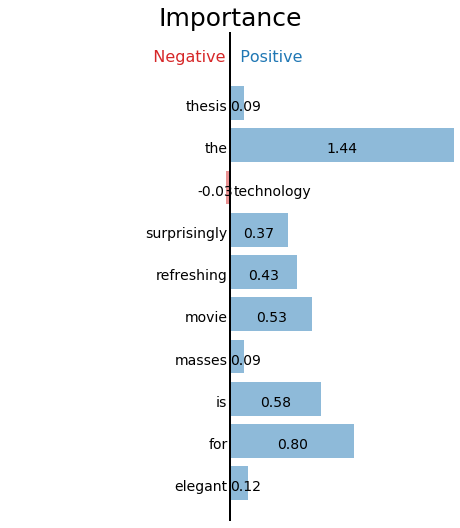

In [26]:
fig, ax = plt.subplots(figsize=(8, 9))
ax.set_title('Importance', fontsize=25)
names = explain_dict['chi_names']
importances = explain_dict['importances']
ax = ExplainGraph.plot_feature_importance(
ax=ax, names=names, vals=importances, size_title=15)
plt.savefig('text_explanation.pdf', dpi=300)

Thank you!